<a href="https://colab.research.google.com/github/VibroGuard/Anomaly-Detection/blob/main/AutoEncoder-Method/Model-1/Model_X_Only_Deliberate_Distortion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model

[[-0.14]
 [-0.03]
 [ 0.01]
 ...
 [-0.04]
 [-0.14]
 [-0.16]]


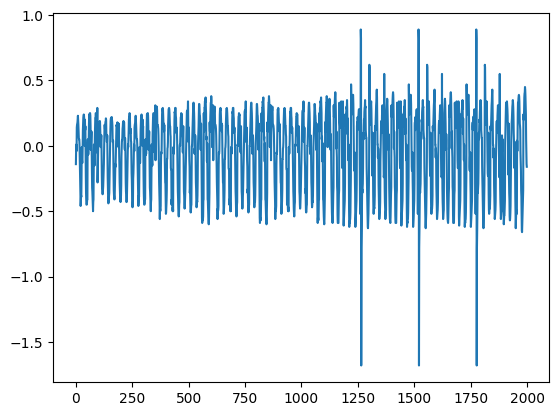

In [181]:
a = 4000  # 4000
b = 6000  # :

with open("x_data.txt", "rt") as x_data_file:
  line = x_data_file.readline()
  x_data = np.array(list(map(float, line.split()))).reshape(-1, 1)[a : b]
  print(x_data)

  plt.plot(x_data)

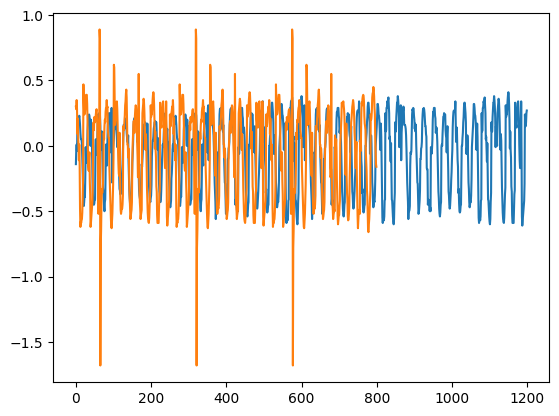

In [182]:
# Divide into train and test datasets.
train_ratio = 0.6

Xtrain = x_data[:int(train_ratio * x_data.size)]
Xtest = x_data[int(train_ratio * x_data.size):]

plt.plot(Xtrain)
plt.plot(Xtest)

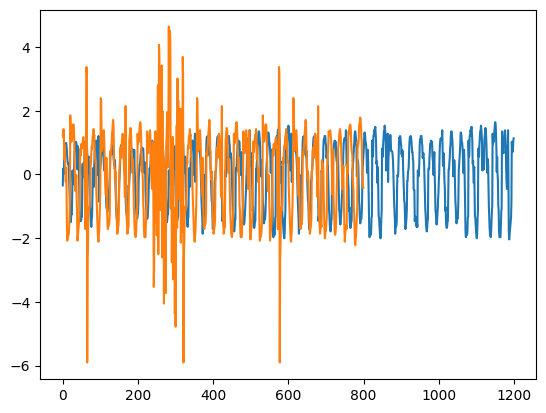

In [186]:
# Deliberately adding distortions to a part of the test data.

length = Xtest.size
Xtest[int(length * 0.3) : int(length * 0.4)] += 0.75 * (np.random.rand(int(length * 0.1)).reshape(-1, 1) - 0.5)

plt.plot(Xtrain)
plt.plot(Xtest)

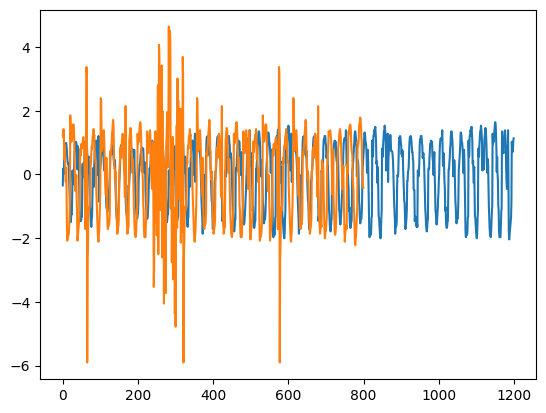

In [187]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized.
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(Xtrain)

Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

plt.plot(Xtrain)
plt.plot(Xtest)

In [188]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
#In this example, the n_features is 2. We will make timesteps = 3.
#With this, the resultant n_samples is 5 (as the input data has 9 rows).

seq_size = 30  # Number of time steps to look back
#Larger sequences (look further back) may improve forecasting.


def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(x.size - seq_size):
        #print(i)
        x_values.append(x[i:(i+seq_size)])
        y_values.append(y[i+seq_size])

    return np.array(x_values), np.array(y_values)

In [189]:
trainX, trainY = to_sequences(Xtrain, Xtrain, seq_size)
testX, testY = to_sequences(Xtest, Xtest, seq_size)

In [190]:
print(Xtrain.shape)
print(Xtest.shape)

print(trainX.shape)
print(trainY.shape)

# print(trainX[:2])

# plt.plot(trainX)
# plt.plot(trainY)

(1200, 1)
(800, 1)
(1170, 30, 1)
(1170, 1)


In [147]:
# model = Sequential()
# model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(rate=0.2))

# model.add(RepeatVector(trainX.shape[1]))

# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(TimeDistributed(Dense(trainX.shape[2])))
# model.compile(optimizer='adam', loss='mae')
# model.summary()

In [148]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(trainX.shape[1]))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(trainX.shape[2])))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 128)           66560     
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector_4 (RepeatVec  (None, 30, 64)            0         
 tor)                                                            
                                                                 
 lstm_14 (LSTM)              (None, 30, 64)            33024     
                                                                 
 lstm_15 (LSTM)              (None, 30, 128)           98816     
                                                                 
 time_distributed_4 (TimeDi  (None, 30, 1)             129       
 stributed)                                           

In [149]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10
33/33 [==============================] - 10s 154ms/step - loss: 0.5643 - val_loss: 0.7965
Epoch 2/10
33/33 [==============================] - 4s 110ms/step - loss: 0.2624 - val_loss: 0.3801
Epoch 3/10
33/33 [==============================] - 4s 123ms/step - loss: 0.1786 - val_loss: 0.3365
Epoch 4/10
33/33 [==============================] - 4s 130ms/step - loss: 0.1458 - val_loss: 0.3704
Epoch 5/10
33/33 [==============================] - 4s 108ms/step - loss: 0.1331 - val_loss: 0.3268
Epoch 6/10
33/33 [==============================] - 4s 111ms/step - loss: 0.1337 - val_loss: 0.3105
Epoch 7/10
33/33 [==============================] - 5s 143ms/step - loss: 0.1286 - val_loss: 0.2930
Epoch 8/10
33/33 [==============================] - 4s 110ms/step - loss: 0.1166 - val_loss: 0.2987
Epoch 9/10
33/33 [==============================] - 4s 110ms/step - loss: 0.1005 - val_loss: 0.2519
Epoch 10/10
33/33 [==============================] - 5s 144ms/step - loss: 0.0872 - val_loss: 0.269

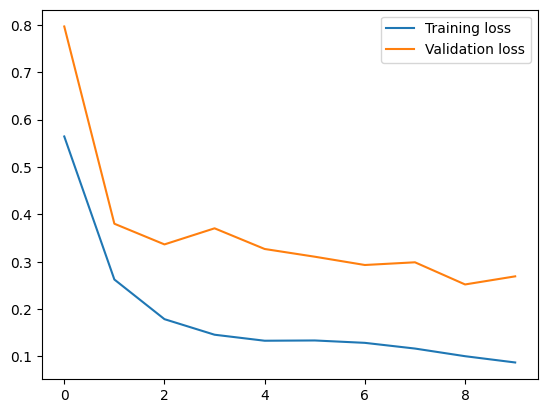

In [191]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

37/37 [==============================] - 1s 37ms/step


(array([  3.,  11.,   6.,   7.,  32.,  55.,  92., 111.,  98.,  93., 119.,
         85.,  97.,  89.,  76.,  61.,  38.,  42.,  19.,   8.,   4.,   4.,
          0.,   1.,   4.,   3.,   4.,   4.,   2.,   2.]),
 array([0.38356159, 0.44180221, 0.50004283, 0.55828344, 0.61652406,
        0.67476468, 0.7330053 , 0.79124592, 0.84948654, 0.90772716,
        0.96596777, 1.02420839, 1.08244901, 1.14068963, 1.19893025,
        1.25717087, 1.31541149, 1.3736521 , 1.43189272, 1.49013334,
        1.54837396, 1.60661458, 1.6648552 , 1.72309582, 1.78133643,
        1.83957705, 1.89781767, 1.95605829, 2.01429891, 2.07253953,
        2.13078015]),
 <BarContainer object of 30 artists>)

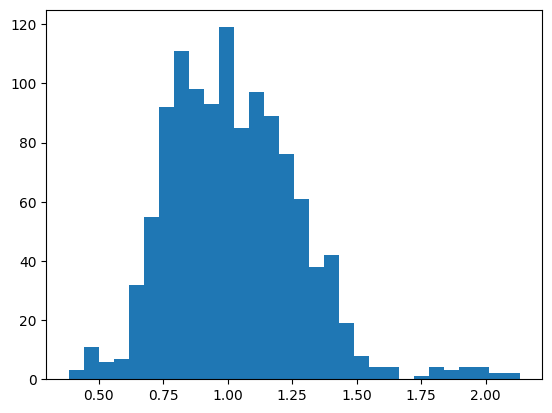

In [192]:
#Anomaly is where reconstruction error is large.
#We can define this value beyond which we call anomaly.
#Let us look at MAE in training prediction

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)

25/25 [==============================] - 1s 37ms/step


(array([303., 326.,  84.,  26.,   8.,   6.,   4.,   3.,   1.,   1.,   2.,
          2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.8294904 ,  1.21068284,  1.59187529,  1.97306773,  2.35426017,
         2.73545262,  3.11664506,  3.4978375 ,  3.87902994,  4.26022239,
         4.64141483,  5.02260727,  5.40379972,  5.78499216,  6.1661846 ,
         6.54737704,  6.92856949,  7.30976193,  7.69095437,  8.07214682,
         8.45333926,  8.8345317 ,  9.21572414,  9.59691659,  9.97810903,
        10.35930147, 10.74049392, 11.12168636, 11.5028788 , 11.88407124,
        12.26526369]),
 <BarContainer object of 30 artists>)

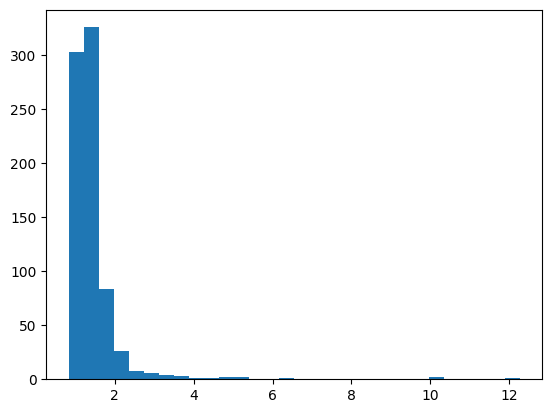

In [193]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

In [194]:
# max_trainMAE = 1.8 #or Define 90% value of max as threshold.
max_trainMAE = np.max(trainMAE) * 0.9
print(max_trainMAE)

1.9177021307129467


In [195]:
print(trainMAE.shape)
print(testMAE.shape)

(1170, 1)
(770, 1)


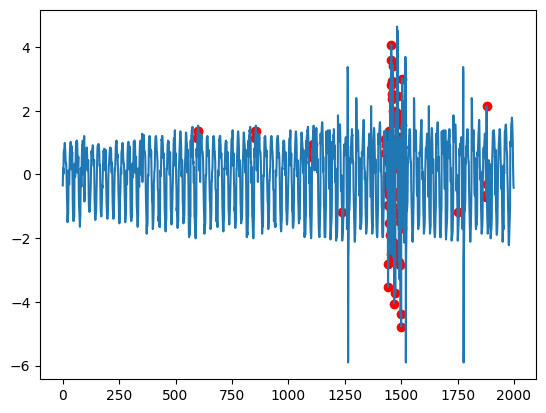

In [196]:
train_anomaly_indices = np.asarray(trainMAE > max_trainMAE).nonzero()[0]
test_anomaly_indices = np.asarray(testMAE > max_trainMAE).nonzero()[0]

anomaly_indices = np.concatenate((train_anomaly_indices.reshape(-1, 1), test_anomaly_indices.reshape(-1, 1) + int(train_ratio * x_data.size)))
anomaly_values = np.concatenate((Xtrain[train_anomaly_indices], Xtest[test_anomaly_indices]))

plt.plot(np.concatenate((Xtrain, Xtest)))
plt.scatter(anomaly_indices, anomaly_values, c="r")

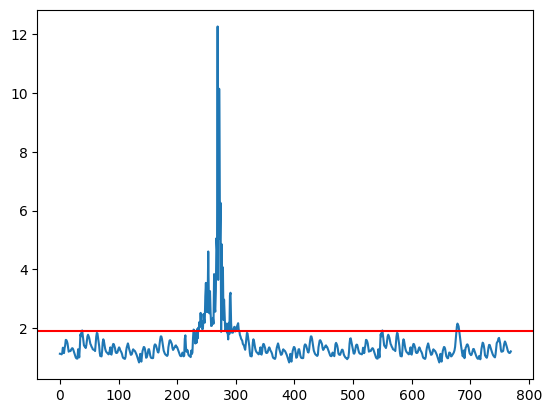

In [199]:
a = 0
b = None

plt.plot(testMAE[a : b])
plt.axhline(y=max_trainMAE, color='r', linestyle='-')